This notebook provides examples to go along with the [textbook](http://manipulation.csail.mit.edu/rl.html).  I recommend having both windows open, side-by-side!

In [1]:
import gymnasium as gym
import numpy as np
import torch
from psutil import cpu_count
from pydrake.all import StartMeshcat

import manipulation.envs.box_flipup  # no-member
from manipulation.meshcat_utils import plot_surface
from manipulation.utils import FindDataResource, RenderDiagram, running_as_notebook

num_cpu = int(cpu_count() / 2) if running_as_notebook else 2

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

2024-01-02 03:17:47.001232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 03:17:47.121910: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-02 03:17:47.126154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-02 03:17:47.126165: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://cabc9393-8bf6-482b-8004-b03070e4d380.deepnoteproject.com/7001/


# RL for box flip-up

## State-feedback policy via PPO (with stiffness control)

In [3]:
observations = "state"
time_limit = 10 if running_as_notebook else 0.5

# Note: Models saved in stable baselines are version specific.  This one
# requires python3.8 (and cloudpickle==1.6.0).
zip = f"box_flipup_ppo_{observations}.zip"


# Use a callback so that the forked process imports the environment.
def make_boxflipup():
    import manipulation.envs.box_flipup

    return gym.make("BoxFlipUp-v0", observations=observations, time_limit=time_limit)


env = make_vec_env(
    make_boxflipup,
    n_envs=num_cpu,
    seed=0,
    vec_env_cls=SubprocVecEnv if running_as_notebook else DummyVecEnv,
)

use_pretrained_model = True
if use_pretrained_model:
    # TODO(russt): Save a trained model that works on Deepnote.
    model = PPO.load(FindDataResource(zip), env)
elif running_as_notebook:
    # This is a relatively small amount of training.  See rl/train_boxflipup.py
    # for a version that runs the heavyweight version with multiprocessing.
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=100000)
else:
    # For testing this notebook, we simply want to make sure that the code runs.
    model = PPO("MlpPolicy", env, n_steps=4, n_epochs=2, batch_size=8)
    model.learn(total_timesteps=4)

2024-01-02 03:17:51.388249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 03:17:51.394427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 03:17:51.615642: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABL

In [7]:
# Make a version of the env with meshcat.
env = gym.make("BoxFlipUp-v0", meshcat=meshcat, observations=observations)

obs, _ = env.reset()
meshcat.StartRecording()
for i in range(500 if running_as_notebook else 5):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated:
        obs, _ = env.reset()
meshcat.PublishRecording()

/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


In [5]:
obs, _ = env.reset()
Q, Qdot = np.meshgrid(np.arange(0, np.pi, 0.05), np.arange(-2, 2, 0.05))
# TODO(russt): tensorize this...
V = 0 * Q
for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        obs[2] = Q[i, j]
        obs[7] = Qdot[i, j]
        with torch.no_grad():
            V[i, j] = (
                model.policy.predict_values(model.policy.obs_to_tensor(obs)[0])[0]
                .cpu()
                .numpy()[0]
            )
V = V - np.min(np.min(V))
V = V / np.max(np.max(V))

meshcat.Delete()
meshcat.ResetRenderMode()
plot_surface(meshcat, "Critic", Q, Qdot, V, wireframe=True)

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.simulator to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.simulator` for environment variables or `env.get_wrapper_attr('simulator')` that will search the reminding wrappers.
  logger.warn(


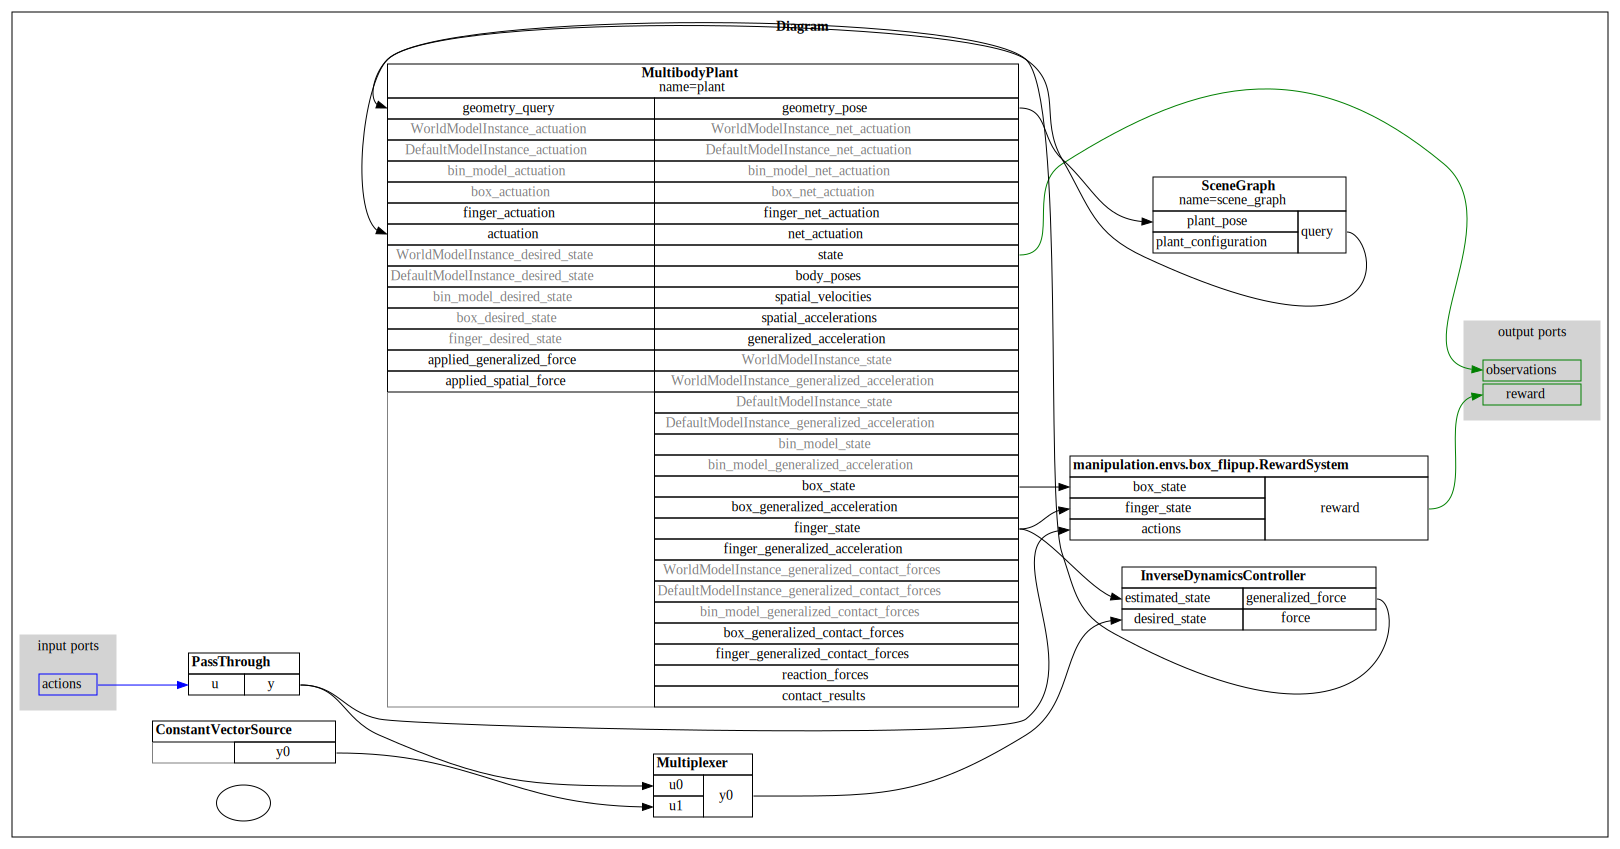

In [6]:
env = gym.make("BoxFlipUp-v0")

RenderDiagram(env.simulator.get_system(), max_depth=1)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cabc9393-8bf6-482b-8004-b03070e4d380' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>